# GPL Paper Section 4.2 Experiment 1: 1D Conservation Law

This code attempts to learn the 1D conservation laws prior
$J(x) = |x|$, with Hamiltonian $H(p) = \frac{1}{2} \|p\|^2_2$, and initial condition $u_0(x) = (1 \quad for \quad x>0, and -1 \quad for \quad x<0)$ . Assuming training data uses $\{y_j, \psi(y_j)\}$ where $\psi(y_j) = 0.5 \|y_j\|^2_2 - S(y_j,1)$ and $S(y_j,1) = \min_{x \in \mathbb{R}} \{0.5 (\|x-y_j\|^{2}_2) + |x|\}$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_4_2_1_1D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

In [2]:

# --- Parameters for Sec 4.2 Exp 1 ---
dim_42 = 1  # Dimension is 1D
data_points_42 = 20000 # Example number of data points
iterations_42= 1000 # Iterations
a_42 = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]
spacing = 50 # Number of points for plotting

# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 10       # beta of softplus
hidden = 50     # number of hidden units
layers = 4      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

# === Section 4.2 ===

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def exp_func(x, gamma):
    if x.ndim > 1 and x.shape[1] == 1:
        x = x.squeeze()
    return 1 - torch.exp(- (torch.norm(x, dim=-1)**2 / gamma)**2)

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    return np.sum(x * x, axis=1)

def prox_l1(y, t_lambda):
    " Proximal operator of t_lambda*|x|, i.e., soft-thresholding"
    return np.sign(y) * np.maximum(np.abs(y) - t_lambda, 0)

def hjsol_true_sec42_exp1(y_points):
    """ Computes the true solution S(y, t=1) for J(x)=|x|,
        S(y, 1) = min_x { 0.5*(x-y)^2 + |x| },
                = 0.5*(prox_|x|(y) - y)^2 + |prox_|x|(y)|"""
    t_moreau = 1.0 # t=1 for the Moreau envelope,
    prox_y = prox_l1(y_points, t_moreau) # y_points is N x 1, prox_y will be N x 1
    # Need to ensure operations are element-wise
    s_values = 0.5 * (prox_y - y_points)**2 + np.abs(prox_y)
    return s_values.flatten() # Return as N-dimensional array

def prior_true_sec42_exp1(y_points):
    """Computes the true prior J(y) = |y| for Section 4.2 Experiment 1
       Args:
           y_points (np.ndarray): N x 1 array of points to evaluate J
       Returns:
           np.ndarray: N-dimensional array of J(y_j) values."""
    return np.abs(y_points).flatten()

def cvx_true_sec42_exp1(y_points):
    """ Computes the target function psi(y) = 0.5*y^2 - S(y, t=1) for Sec 4.2 Exp 1
        This is the function the LPN is trained to approximate
        Args:
            y_points (np.ndarray): N x 1 array of points (y_j)
        Returns:
            np.ndarray: N-dimensional array of psi(y_j) values"""
    s_y_1 = hjsol_true_sec42_exp1(y_points.reshape(-1,1)) # Ensure y_points is N x 1 for hjsol
    # euclid_norm_sq expects N x dim, for 1D, y_points should be N x 1
    psi_y = 0.5 * euclid_norm_sq(y_points.reshape(-1,1)) - s_y_1 
    return psi_y.flatten()


# --- Functions for evaluating the learned LPN model (adapted from notebook) ---

def invert_prior(x, model, INVERT_MODE):
    """ 
    This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}psi denotes the gradient of the LPN network.
    
    Args:
        x (np.ndarray): A numpy array of real numbers at which to invert the prior.
        model: The trained LPN model object.
        INVERT_MODE: The method for inverting the LPN network.

    Returns:
        np.ndarray: The (approximate) set of points y for which nabla_{y}psi(y) = x.
    """
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_sec42_exp1(x_eval_points, y_inverted_points, model):
    """ 
    This function evaluates the learned prior J_est(x_eval_points) using the LPN.
    It uses y_inverted_points where x_eval_points = nabla_psi(y_inverted_points).
    The formula used is J_est(x) = <x, y> - 0.5 * ||x||^2 - psi(y)
    
    Args:
        x_eval_points (np.ndarray): N x dim array of points at which to estimate the prior J(x).
        y_inverted_points (np.ndarray): N x dim_psi array of points y such that x_eval_points = nabla_psi(y_inverted_points).
                                       dim_psi is the input dimension to the LPN.
        model: The trained LPN model object (e.g., a torch.nn.Module).

    Returns:
        np.ndarray: N-dimensional array of estimated prior values J_est(x_eval_points).
    """
    # Ensure y_inverted_points is a torch tensor for model input
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: # device might not be defined if torch is not fully set up
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    

    x_eval_reshaped = x_eval_points.reshape(-1,1)
    y_inverted_reshaped = y_inverted_points.reshape(-1,1)
    prior_est = inner_prod(x_eval_reshaped, y_inverted_reshaped) - 0.5 * euclid_norm_sq(x_eval_reshaped) - psi_of_y_inverted
    return prior_est.flatten()

# --- Plotting tools (Modified) ---

# def compute_square_cross_sections(a, spacing, dim):
#     ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
#     on the grid [-a,a]^{dim} along the first and second dimensions.
#     '''
#     xi = np.linspace(-a, a, spacing)
#     grid = np.zeros((xi.size, dim))
#     x1_0_points = np.copy(grid)
#     x1_0_points[:, 0] = xi
    
#     x2_0_points = np.copy(grid)
#     if dim > 1: # Ensure we don't try to access index 1 if dim is 1
#         x2_0_points[:, 1] = xi
#     elif dim == 1: # For 1D, x2_0_points is not really a "second axis" cross-section
#         x2_0_points = x1_0_points.copy() # Or handle as appropriate for 1D plots

#     return xi, x1_0_points, x2_0_points

def compute_1d_points(a, spacing):
    xi = np.linspace(-a, a, spacing)
    points_1d = xi.reshape(-1, 1)
    return xi, points_1d

def plots_sec42_exp1(model, a, spacing, INVERT_MODE, dim):
    if dim != 1:
        raise ValueError("This plotting function is for 1D experiments.")

    xi, eval_points = compute_1d_points(a, spacing)
    psi_true_vals = cvx_true_sec42_exp1(eval_points)
    J_true_vals = prior_true_sec42_exp1(eval_points)
    psi_est_vals = cvx(eval_points, model)

    y_inverted_for_J_est = invert_prior(eval_points, model, INVERT_MODE)
    J_est_vals = evaluate_learned_prior_sec42_exp1(eval_points, y_inverted_for_J_est, model)

    plt.figure()
    plt.plot(xi, psi_est_vals, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, psi_true_vals, "--", ms=5, label="True $\\psi$ (Sec 4.2 Exp 1)")
    plt.grid(True)
    plt.title("Learned vs True $\\psi(y)$ - 1D, $J(x)=|x|$")
    plt.xlabel('$y$')
    plt.ylabel('$\\psi(y)$')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(xi, J_est_vals, "-", label="LPN (Learned $J$)")
    plt.plot(xi, J_true_vals, "--", label="True $J$ (Sec 4.2 Exp 1)")
    plt.grid(True)
    plt.title("Learned vs True Prior $J(x)$ - 1D, $J(x)=|x|$")
    plt.xlabel('$x$')
    plt.ylabel('$J(x)$')
    plt.legend()
    plt.show()

def plot_all_sec42_exp1(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting for Sec 4.2 Exp 1 (Dim={dim}) ---")
    plots_sec42_exp1(model, a, spacing, INVERT_MODE, dim)


# --- Generate Training Data (using Moreau envelope target as per notebook) ---

In [4]:
# --- Generate Training Data (using Moreau envelope target as per notebook) ---
# Sample y_j points (uniformly on [-a, a]^n grid)
y_j_42= np.zeros((dim_42,data_points_42))

if(dim_42>1):
    for k in range(0,dim_42):
        y_j_42[k] = np.random.uniform(-a_42,a_42,data_points_42)
else:
    y_j_42 = np.random.uniform(-a_42,a_42,data_points_42)

#y_j_41 = np.random.uniform(-a_41, a_41, data_points_41)
y_j_42 = y_j_42.reshape(data_points_42,dim_42)

# Calculate target psi(y_j) = 0.5*y_j^2 - S(y_j, 1) for J(x)=|x|
cvx_samples_42 = cvx_true_sec42_exp1(y_j_42) # cvx_true_sec42_exp1 expects N x 1 and returns N
cvx_samples_42 = cvx_samples_42.reshape(-1, 1) # Reshape for loss calculation (N x 1)
# Recast the samples as tensors
y_j_42 = torch.from_numpy(y_j_42).float()
cvx_samples_42 = torch.from_numpy(cvx_samples_42).float()

print(f"Generated training data: y_j_tensor_exp shape {y_j_42.shape}, cvx_samples_tensor_exp shape {cvx_samples_42.shape}")

Generated training data: y_j_tensor_exp shape torch.Size([20000, 1]), cvx_samples_tensor_exp shape torch.Size([20000, 1])


## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:

# --- Train LPN for Case 3 ---
print("--- Training LPN for Exp_42 ---")
lpn_model_42 = LPN(in_dim=dim_42, hidden=64, layers=5, beta=10,eps=0.01).to(device)
optimizer_42 = torch.optim.Adam(lpn_model_42.parameters(), lr=1e-4)

for i in range(iterations_42):
     single_iteration(i, data_points_42, lpn_model_42, optimizer_42, y_j_42,cvx_samples_42,loss_type=2,gamma_loss=None) # Using MSE

for g in optimizer_42.param_groups:
    g["lr"] = 1e-4
for i in range(30000):
    single_iteration(i, data_points_42, lpn_model_42, optimizer_42, y_j_42,cvx_samples_42,loss_type=2,gamma_loss=None)

# save the model
torch.save(lpn_model_42.state_dict(), os.path.join(MODEL_DIR, "exp_42_l2.pth"))

--- Training LPN for Exp_42 ---
iteration 0 loss 9.847654342651367
iteration 500 loss 18.14817237854004
iteration 0 loss 4.343362331390381
iteration 500 loss 1.7533451318740845
iteration 1000 loss 0.9297541975975037
iteration 1500 loss 0.5550307035446167
iteration 2000 loss 0.37350770831108093
iteration 2500 loss 0.2887023091316223
iteration 3000 loss 0.2477908879518509
iteration 3500 loss 0.22823747992515564
iteration 4000 loss 0.21693673729896545
iteration 4500 loss 0.2071511298418045
iteration 5000 loss 0.19606101512908936
iteration 5500 loss 0.1827407032251358
iteration 6000 loss 0.16657671332359314
iteration 6500 loss 0.1465107798576355
iteration 7000 loss 0.11993115395307541
iteration 7500 loss 0.08842243999242783
iteration 8000 loss 0.05805036053061485
iteration 8500 loss 0.03534796088933945
iteration 9000 loss 0.021078942343592644
iteration 9500 loss 0.013326040469110012
iteration 10000 loss 0.008933622390031815
iteration 10500 loss 0.006185462698340416
iteration 11000 loss 0.0

L2 loss -- Plot

loss -0.2216130495071411
loss -51.04214859008789
loss -101.65122985839844
loss -144.18283081054688
loss -173.86322021484375
loss -195.4214630126953
loss -211.08535766601562
loss -222.06178283691406
loss -229.65599060058594
loss -234.61221313476562
loss -237.72506713867188
loss -240.26258850097656
loss -242.2653350830078
loss -244.15142822265625
loss -246.10565185546875
loss -248.11209106445312
loss -250.20018005371094
loss -252.35386657714844
loss -254.5341033935547
loss -256.734375
loss -258.9598388671875
loss -261.1859130859375
loss -263.425048828125
loss -265.6792297363281
loss -267.9216613769531
loss -270.1723327636719
loss -272.4267578125
loss -274.6864929199219
loss -276.9417419433594
loss -279.1865234375
loss -281.41705322265625
loss -283.64404296875
loss -285.8684997558594
loss -288.0955505371094
loss -290.3223571777344
loss -292.5335388183594
loss -294.7279357910156
loss -296.9172058105469
loss -299.1000061035156
loss -301.2838134765625
final mse:  0.04874854162335396
max, min

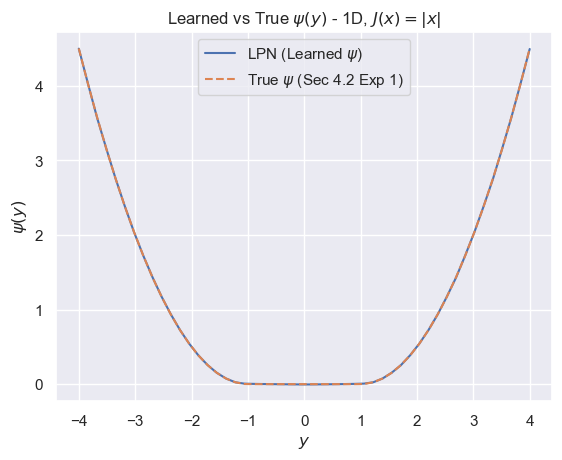

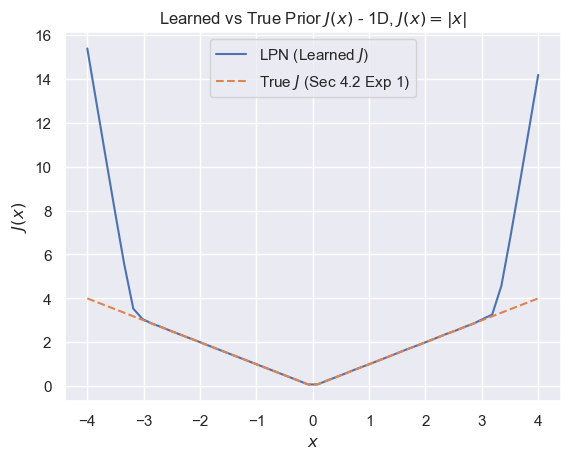

In [7]:
plots_sec42_exp1(lpn_model_42, a_42, spacing, INVERT_MODE, dim_42)

L1 loss -- Train

In [8]:

# --- Train LPN for Case 3 ---
print("--- Training LPN for Exp_42 ---")
lpn_model_42 = LPN(in_dim=dim_42, hidden=64, layers=5, beta=10,eps=0.01).to(device)
optimizer_42 = torch.optim.Adam(lpn_model_42.parameters(), lr=1e-4)

for i in range(iterations_42):
     single_iteration(i, data_points_42, lpn_model_42, optimizer_42, y_j_42,cvx_samples_42,loss_type=1,gamma_loss=None) # Using MSE

for g in optimizer_42.param_groups:
    g["lr"] = 1e-4
for i in range(30000):
    single_iteration(i, data_points_42, lpn_model_42, optimizer_42, y_j_42,cvx_samples_42,loss_type=1,gamma_loss=None)

# save the model
torch.save(lpn_model_42.state_dict(), os.path.join(MODEL_DIR, "exp_42_l1.pth"))

--- Training LPN for Exp_42 ---
iteration 0 loss 1.7736387252807617
iteration 500 loss 1.8416723012924194
iteration 0 loss 1.0793977975845337
iteration 500 loss 0.9314512014389038
iteration 1000 loss 0.8321597576141357
iteration 1500 loss 0.7070262432098389
iteration 2000 loss 0.524833619594574
iteration 2500 loss 0.32455188035964966
iteration 3000 loss 0.2702654302120209
iteration 3500 loss 0.2386689931154251
iteration 4000 loss 0.2102707028388977
iteration 4500 loss 0.18640334904193878
iteration 5000 loss 0.16474534571170807
iteration 5500 loss 0.1437428593635559
iteration 6000 loss 0.12605610489845276
iteration 6500 loss 0.11161458492279053
iteration 7000 loss 0.09370478987693787
iteration 7500 loss 0.07807805389165878
iteration 8000 loss 0.06713695079088211
iteration 8500 loss 0.05124639719724655
iteration 9000 loss 0.03853164240717888
iteration 9500 loss 0.029109375551342964
iteration 10000 loss 0.02388656511902809
iteration 10500 loss 0.019288331270217896
iteration 11000 loss 0.0

L1 loss -- Plot

loss -0.05299057811498642
loss -51.00754165649414
loss -101.82462310791016
loss -144.09658813476562
loss -173.7215576171875
loss -195.27244567871094
loss -210.8294677734375
loss -221.8271484375
loss -229.37628173828125
loss -234.30274963378906
loss -237.50445556640625
loss -240.1400146484375
loss -242.72979736328125
loss -245.51998901367188
loss -248.54931640625
loss -251.80087280273438
loss -255.21624755859375
loss -258.75079345703125
loss -262.368896484375
loss -266.02996826171875
loss -269.71124267578125
loss -273.4152526855469
loss -277.1418151855469
loss -280.8716735839844
loss -284.6065368652344
loss -288.32952880859375
loss -292.0507507324219
loss -295.7669677734375
loss -299.4822692871094
loss -303.20233154296875
loss -306.9248352050781
loss -310.64862060546875
loss -314.36767578125
loss -318.0865478515625
loss -321.8063049316406
loss -325.51849365234375
loss -329.2174987792969
loss -332.9114074707031
loss -336.5932922363281
loss -340.2608642578125
final mse:  0.106736250221729

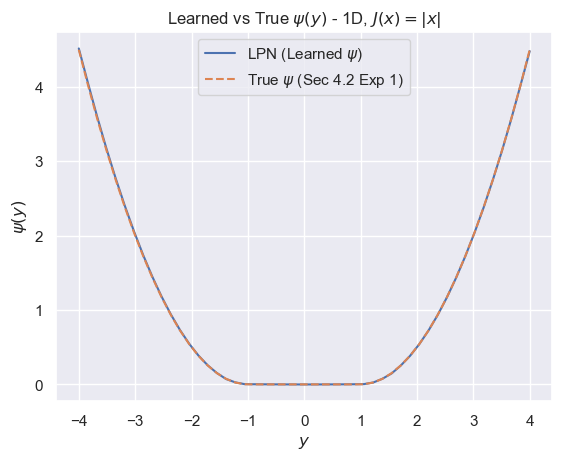

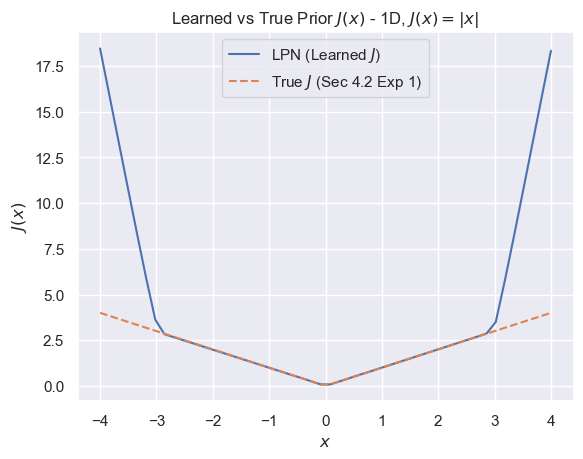

In [9]:
plots_sec42_exp1(lpn_model_42, a_42, spacing, INVERT_MODE, dim_42)

Proximal matching loss.
We perform proximal matching loss with a decreasing sequence of gamma parameters.

gamma = 20 -- Train

In [10]:
# lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
# optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

# loss_type = 0
# gamma_loss = 20

# # set learning rate
# for g in optimizer.param_groups:
#     g["lr"] = 1e-4

# for i in range(3000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(3000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 20 -- Plot

In [11]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

gamma = 12.5 -- Train

In [12]:
# gamma_loss = 12.5

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(6000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 12.5 -- Plot

In [13]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

gamma = 10 -- Train

In [14]:
# gamma_loss = 10

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(10000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 10 -- Plot

In [15]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)